In [2]:
# Set active directory to project root and configure logging
import os
import logging
from molecule.config import get_project_root_directory
ROOT_PATH = get_project_root_directory()
os.chdir(ROOT_PATH)
logging.basicConfig(level=logging.INFO)

In [3]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [4]:
from molecule.prediction.model import FeatureType
from molecule.representation.dataset import Dataset

INFO:rdkit:Enabling RDKit 2022.03.4 jupyter extensions


# Data and features imports

In [5]:
dataset_train = Dataset("data/datasets/dataset_single_train.csv")
dataset_test = Dataset("data/datasets/dataset_single_test.csv")

In [6]:
X_train, y_train = dataset_train.get_features(FeatureType.MORGAN), dataset_train.labels
X_test, y_test = dataset_test.get_features(FeatureType.MORGAN), dataset_test.labels
print(f"Size of training features: {X_train.shape}")
print(f"Size of test features: {X_test.shape}")

Size of training features: (3999, 2048)
Size of test features: (1000, 2048)


# Baselines

Let's start by exploring a few baseline models.

## Naive Bayes

In [8]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

Since the features are binary, it is tempting to start by training a naive bayes model based on a Bernouilli distribution.

In [9]:
naive_bayes_clf = BernoulliNB(binarize=None)
naive_bayes_clf.fit(X_train, y_train)

BernoulliNB(binarize=None)

In [10]:
predicted_proba = naive_bayes_clf.predict_proba(X_test)[:,1]
predicted_class = naive_bayes_clf.predict(X_test)

Let's look at the performance of this first model.

In [11]:
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.32      0.49      0.39       178
           1       0.88      0.77      0.82       822

    accuracy                           0.72      1000
   macro avg       0.60      0.63      0.60      1000
weighted avg       0.78      0.72      0.74      1000



The accuracy (72%) is not better than that of the naive "yes" model predicting always 1 (82%). This is not so surprising, as we saw that the dataset is imbalanced and the task seems challenging.

This model has better precision (88%) than the "yes" model, but worse recall (77%), hence the impact on the accuracy.

Let's see if the naive bayes still captures some information regarding the distribution of the label with respect to the training features. We can use a ROC curve.

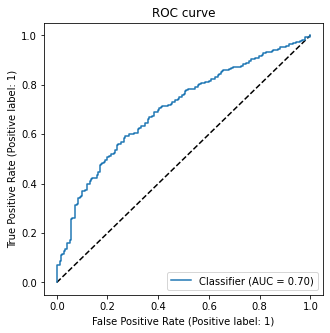

In [12]:
fig = plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], "--k");plt.title("ROC curve")
RocCurveDisplay.from_predictions(y_test, predicted_proba, ax=fig.axes[0])
plt.show()

The model performs significantly better than the random baseline or the "yes" model.

The Naive Bayes model is good at identifying positive samples (bottom left), but not so good at identifying negative samples (top right).
We can expect a good precision for high decision thresholds.

Let's have a look at the full precision recall curve.

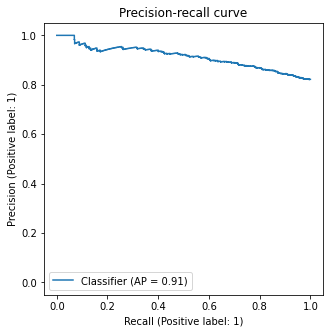

In [13]:
fig = plt.figure(figsize=(5,5))
plt.ylim([-.05,1.05]);plt.title("Precision-recall curve")
PrecisionRecallDisplay.from_predictions(y_test, predicted_proba, ax=fig.axes[0])
plt.show()

As we expected based on the ROC curve earlier, the model is good at identifying the P1 property with high certainty for some samples.

We can try training more complex models.

## Random forest

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Let's train a random forest, so that we can model more complex relationships between features.

We'll use a grid search cross-validation to select the hyper-parameters. We will use the auc as our objective metric. To simplify thing, we'll only focus on the max tree depth.

In [15]:
%%time
hyperparameters = {"max_depth": [2, 5, 10, 20]}
random_forest_clf = GridSearchCV(RandomForestClassifier(random_state=42),
            hyperparameters, scoring="roc_auc")
random_forest_clf.fit(X_train, y_train)

CPU times: user 17.4 s, sys: 90 ms, total: 17.5 s
Wall time: 17.5 s


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 5, 10, 20]}, scoring='roc_auc')

In [16]:
aucs = random_forest_clf.cv_results_["mean_test_score"]
print(f"Cross validation AUCs: {aucs}")

Cross validation AUCs: [0.65720342 0.67000207 0.67302744 0.66308584]


Let's make predictions with the best hyperparameters (max_depth=5) with the model trained on the full training set.

In [17]:
predicted_proba = random_forest_clf.predict_proba(X_test)[:,1]

In [18]:
auc = roc_auc_score(y_test, predicted_proba)
print(f"AUC on test set: {auc:.3f}")

AUC on test set: 0.693


We do not have better results than with the naive bayes. This may suggest that there is not much more signal to extract from the data.

## LightGBM

In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

Let's try a final "baseline" before the deep learning approach: the gradient-boosting approach LightGBM has the advantage of being fast, typically offer good performance, and does not usually require much hyper-parameter tuning.

Let's further split the training dataset into 1 training and 1 validation set, so that we can use the validation to do early stopping (other hyper-parameters have been played with and do not have much impact on the final score).

In [20]:
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.125, random_state=42)
print(f"Size of training features: {X_train_.shape}")
print(f"Size of validation features: {X_val_.shape}")

Size of training features: (3499, 2048)
Size of validation features: (500, 2048)


In [21]:
train_data = lgb.Dataset(X_train_, label=y_train_)
validation_data = lgb.Dataset(X_val_, label=y_val_)

Now we can train the model.

In [22]:
param = {"num_leaves": 30, "objective": "binary", "metric": "auc"}
bst = lgb.train(param, train_data, 10, valid_sets=[validation_data], early_stopping_rounds=5)

[LightGBM] [Info] Number of positive: 2878, number of negative: 621


/home/yannick/miniconda3/envs/servier/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2498
[LightGBM] [Info] Number of data points in the train set: 3499, number of used features: 1249
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.822521 -> initscore=1.533520
[LightGBM] [Info] Start training from score 1.533520
[1]	valid_0's auc: 0.585664
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.642876
[3]	valid_0's auc: 0.646646
[4]	valid_0's auc: 0.649257
[5]	valid_0's auc: 0.658261
[6]	valid_0's auc: 0.652773
[7]	valid_0's auc: 0.655264
[8]	valid_0's auc: 0.667799
[9]	valid_0's auc: 0.671808
[10]	valid_0's auc: 0.670237
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.671808


Let's evaluate the result on the test set.

In [23]:
predicted_proba = bst.predict(X_test)
auc = roc_auc_score(y_test, predicted_proba)
print(f"Auc: {auc:.3f}")

Auc: 0.686


Again, we don't observe any improvement over the naive bayes baseline. This constinues to suggest that achieving much higher performance will be challenging.

# Deep learning model

In [7]:
from sklearn.metrics import (
    classification_report, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)

In [8]:
from molecule.prediction.model import Model
from molecule.prediction.model import FeatureType
import utils

Let's now try a deep learning model, as specified in the instructions.

The architecture is described in molecule.predictors.deep_architectures.ModelMorgan. To summarize, the model consists in a 3-layer fully-connected neural network, with dropout. It was inspired by [1], who used a similar architecture on a similar task.

[1] Yoshimori et al., Prediction of Molecular Properties Using Molecular Topographic Map, Molecule, 2021 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8348331/)

## Training

In [9]:
model = Model(FeatureType.MORGAN)

INFO:root:Using CUDA for training and inference.


Let's train the model using the default training parameters defined in the architecture module. We will monitor the evolution of the training and validation losses, as well as the validation AUC.

**WARNING**: it is advised to have a GPU to train the model. Otherwise, you can load a pre-trained model using the provided functions and pre-trained models.

In [10]:
train_losses, val_losses, val_aucs = model.fit(X_train, y_train, validation_set_ratio=0.2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.68it/s]


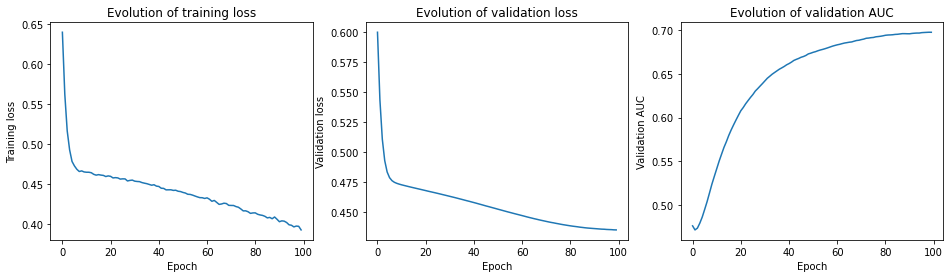

In [11]:
utils.plot_training_curves(train_losses, val_losses, val_aucs)

## Performance evaluation

Let's measure the final performance of the model. We will start with the AUC, which is our main metric for this task.

In [12]:
predicted_proba = model.predict_proba(X_test)

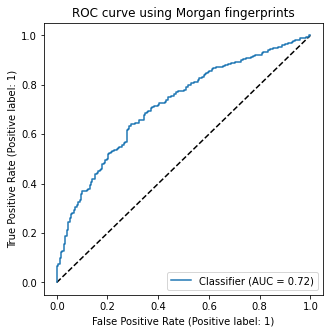

In [13]:
fig = plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], "--k");plt.title("ROC curve using Morgan fingerprints")
RocCurveDisplay.from_predictions(y_test, predicted_proba, ax=fig.axes[0])
plt.show()

The AUC (0.72) is a bit higher than what we obtained with the other models, although not drastically higher.

Let's also look at the performance if we discretize the predictions.

In [14]:
predicted_class = model.predict(X_test)

In [15]:
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       178
           1       0.82      1.00      0.90       822

    accuracy                           0.82      1000
   macro avg       0.41      0.50      0.45      1000
weighted avg       0.68      0.82      0.74      1000



/home/yannick/miniconda3/envs/servier/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yannick/miniconda3/envs/servier/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yannick/miniconda3/envs/servier/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [16]:
print(f"Ratio of predicted 1s: {predicted_class.mean():.3f}")

Ratio of predicted 1s: 1.000


Funnily enough, the model only predicts 1s, hence the recall of 1, and the precision equal to the accuracy equal to the ratio of 1s in the dataset.

This is not super surprising, as the model mostly contains 1s and as evidenced by the angles at the extremities of the ROC curve, the model is better at identifying molecules with high probability of having property P1 than molecules with low probability.

## Performance with higher decision threshold

The model may still be useful though, as it can be used to identify molecules with higher probability than average of having property P1. This can be evidenced by the precision recall curve:

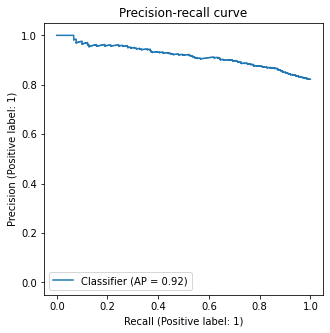

In [17]:
fig = plt.figure(figsize=(5,5))
plt.ylim([-.05,1.05]);plt.title("Precision-recall curve")
PrecisionRecallDisplay.from_predictions(y_test, predicted_proba, ax=fig.axes[0])
plt.show()

Let's change the decision threshold to identify such molecules.

In [18]:
predicted_class = model.predict(X_test, decision_threshold=0.95)

In [19]:
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.19      0.99      0.32       178
           1       0.98      0.08      0.14       822

    accuracy                           0.24      1000
   macro avg       0.59      0.54      0.23      1000
weighted avg       0.84      0.24      0.17      1000



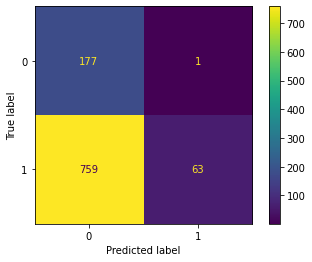

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, predicted_class);

Here, we have identified 64 promising molecules, 63 of which (i.e. 98%) have the desired property, as opposed to 82% in the rest of the dataset.

As a final note, other deep learning architectures have been tested, and yielded comparable results.

*Post-final note: in general, I would not advise using this deep learning model on this task in production. Similar performance could very likely be achieved by fine-tuning a simpler model, without the added complexity of defining the architecture, performing stochastic gradient etc and needing GPUs for fast training).*